In [76]:
from sdm.utils import set_project_wd
set_project_wd()

Current Working Directory: /Users/matthewwhittle/Data Science/shefflied-bats


In [77]:
import geopandas as gpd
import rioxarray as rxr
import numpy as np
import xarray as xr
import mlflow

Load the boundary file, this is the county of south yorkshire with a buffer applied.

<Axes: >

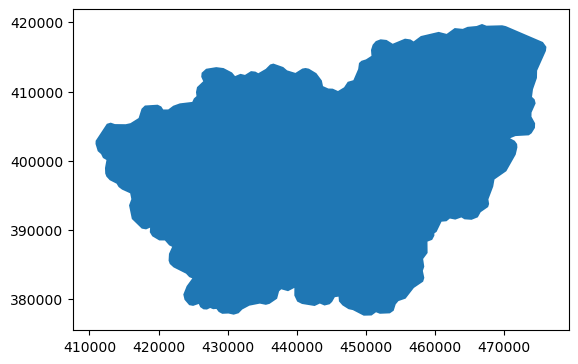

In [78]:
boundary = gpd.read_file('data/processed/boundary.geojson')
boundary.plot()

# Load the datasets

The modelling will use the following datasets:
- Digital Surface Model (DSM) & Digital Terrain Model (DTM) to derive a canopy height model (CHM) which is a key feature in predicting vegetation height
- Sentinel-2 (S2) imagery to classify pixels as vegetation or non-vegetation
- Vegetation height data from the Environment Agency (EA) to train the model. This data has gaps so can't be used directly.

In [79]:
dtm = rxr.open_rasterio('data/processed/dtm-10m.tif')
dsm = rxr.open_rasterio('data/processed/dsm-10m.tif')
veg_height = rxr.open_rasterio('data/processed/vegetation-height.tif')

In [80]:
# Sentinel-2
sentinel_2 = xr.open_mfdataset('data/raw/big-files/sentinel-2/*.tif', combine='by_coords', engine="rasterio")
sentinel_2

<xarray.Dataset>
Dimensions:      (band: 12, x: 10988, y: 4212)
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * x            (x) float64 -1.837 -1.837 -1.837 ... -0.8506 -0.8505 -0.8504
  * y            (y) float64 53.67 53.67 53.67 53.67 ... 53.29 53.29 53.29 53.29
    spatial_ref  int64 0
Data variables:
    band_data    (band, y, x) float64 dask.array<chunksize=(1, 256, 256), meta=np.ndarray>

In [81]:
# From earth engine
band_names = list(sentinel_2.band_data.attrs['long_name'])
sentinel_2 = sentinel_2.band_data.to_dataset(dim='band').rename({i + 1: "s2_" + band_names[i] for i in range(12)})
sentinel_2

<xarray.Dataset>
Dimensions:      (y: 4212, x: 10988)
Coordinates:
  * x            (x) float64 -1.837 -1.837 -1.837 ... -0.8506 -0.8505 -0.8504
  * y            (y) float64 53.67 53.67 53.67 53.67 ... 53.29 53.29 53.29 53.29
    spatial_ref  int64 0
Data variables:
    s2_B1        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B2        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B3        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B4        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B5        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B6        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B7        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B8        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B8A       (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B9        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B11       (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B12       (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        4884
    STATISTICS_MEAN:           1371.1649519329
    STATISTICS_MINIMUM:        1053.5
    STATISTICS_STDDEV:         241.71580333102
    STATISTICS_VALID_PERCENT:  100
    long_name:                 ('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8...

# No Data Values

In [82]:
# Convert the nodata values to np.nan and write them for each dataset variable


def write_nodata(array):
    nodata_value = array.rio.nodata
    if nodata_value is not None:
        array = array.where(array != nodata_value, np.nan)
    array.rio.write_nodata(np.nan, inplace=True)
    return array

sentinel_2_arr = sentinel_2.to_array()
sentinel_2_arr = write_nodata(sentinel_2_arr)
sentinel_2 = sentinel_2_arr.to_dataset(dim='variable')

dtm = write_nodata(dtm)
dsm = write_nodata(dsm)
veg_height = write_nodata(veg_height)



# Clip the data to the boundary bbox

In [83]:
boundary_buffer = boundary.copy()
boundary_buffer["geometry"] = boundary.buffer(7000)
bbox = tuple(boundary_buffer.total_bounds)


sentinel_2 = sentinel_2.rio.clip_box(*bbox, crs=boundary_buffer.crs)
dtm = dtm.rio.clip_box(*bbox, crs=boundary_buffer.crs)
dsm = dsm.rio.clip_box(*bbox, crs=boundary_buffer.crs)
veg_height = veg_height.rio.clip_box(*bbox, crs=boundary_buffer.crs)

# Align the Rasters

To model the data the rasters all need to be aligned so that a pixel in one raster corresponds to the same location as a pixel in another raster.

In [84]:
veg_height = veg_height.rio.reproject_match(sentinel_2)
dsm = dsm.rio.reproject_match(sentinel_2)
dtm = dtm.rio.reproject_match(sentinel_2)

# Drop the band dimension 
veg_height = veg_height.squeeze()
dsm = dsm.squeeze()
dtm = dtm.squeeze()

The arrays need to be converted to datasets with variable names and then stacked with the sentinel image.

In [85]:
dsm = dsm.to_dataset(name='dsm')
dtm = dtm.to_dataset(name='dtm')
veg_height = veg_height.to_dataset(name='veg_height')

In [86]:
image_stack = xr.merge([sentinel_2, dsm, dtm, veg_height])

In [87]:
image_stack

<xarray.Dataset>
Dimensions:      (x: 10988, y: 4212)
Coordinates:
  * x            (x) float64 -1.837 -1.837 -1.837 ... -0.8506 -0.8505 -0.8504
  * y            (y) float64 53.67 53.67 53.67 53.67 ... 53.29 53.29 53.29 53.29
    spatial_ref  int64 0
    band         int64 1
Data variables: (12/15)
    s2_B1        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B2        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B3        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B4        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B5        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B6        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    ...           ...
    s2_B9        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B11       (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B12       (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    dsm          (y, x) float32 230.8 230.8 231.8 231.8 ... 28.94 29.2 29.2 29.7
    dtm          (y, x) float32 230.8 230.8 231.8 231.8 ... 29.2 29.2 29.69
    veg_height   (y, x) float32 nan nan nan nan nan ... 1.165 1.165 0.0 0.0 0.0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        4884
    STATISTICS_MEAN:           1371.1649519329
    STATISTICS_MINIMUM:        1053.5
    STATISTICS_STDDEV:         241.71580333102
    STATISTICS_VALID_PERCENT:  100
    long_name:                 ('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8...
    _FillValue:                nan

# Create the training dataset

- Sample the data to train using a subset

In [88]:
image_df = image_stack.to_dask_dataframe()
image_samples = image_df.sample(frac=0.05).compute()
print("Number of samples: ", len(image_samples))
image_samples.head()

Number of samples:  2314093


,x,y,spatial_ref,band,s2_B1,s2_B2,s2_B3,s2_B4,s2_B5,s2_B6,s2_B7,s2_B8,s2_B8A,s2_B9,s2_B11,s2_B12,dsm,dtm,veg_height
33526,-1.83674,53.308050,0,1,1199.0,1342.5,1630.0,1425.0,1968.0,3637.0,4148.0,4272.0,4368.5,5086.5,2793.0,1887.5,320.528290,320.514313,0.0
27635,-1.83683,53.458877,0,1,1238.0,1298.5,1511.5,1393.5,2078.0,3219.0,3585.5,3893.0,3988.0,4060.5,3079.5,1967.0,565.174133,565.175415,0.0
14613,-1.83710,53.493552,0,1,1305.0,1398.0,1625.0,1732.5,2506.5,4347.0,4917.5,5006.0,5408.5,5056.0,3638.5,2375.0,298.229309,298.210632,0.0
13734,-1.83710,53.572514,0,1,1356.0,1496.0,1896.0,1704.0,2453.0,3855.0,4240.0,5056.0,4598.0,4928.0,3418.0,2337.0,352.767731,352.767517,0.0
27424,-1.83683,53.477832,0,1,1275.0,1279.5,1330.5,1377.5,1943.0,3028.0,3317.0,3515.0,3711.0,3813.5,2911.5,2011.0,529.462830,529.457947,0.0


## Exploratory Analysis


In [89]:
# Remove rows with a missing value
image_samples = image_samples.dropna()

# Calculate the vegetation height
image_samples['chm'] = image_samples['dsm'] - image_samples['dtm']
image_samples

,x,y,spatial_ref,band,s2_B1,s2_B2,s2_B3,s2_B4,s2_B5,s2_B6,s2_B7,s2_B8,s2_B8A,s2_B9,s2_B11,s2_B12,dsm,dtm,veg_height,chm
33526,-1.836740,53.308050,0,1,1199.0,1342.5,1630.0,1425.0,1968.0,3637.0,4148.0,4272.0,4368.5,5086.5,2793.0,1887.5,320.528290,320.514313,0.000,0.013977
27635,-1.836830,53.458877,0,1,1238.0,1298.5,1511.5,1393.5,2078.0,3219.0,3585.5,3893.0,3988.0,4060.5,3079.5,1967.0,565.174133,565.175415,0.000,-0.001282
14613,-1.837100,53.493552,0,1,1305.0,1398.0,1625.0,1732.5,2506.5,4347.0,4917.5,5006.0,5408.5,5056.0,3638.5,2375.0,298.229309,298.210632,0.000,0.018677
13734,-1.837100,53.572514,0,1,1356.0,1496.0,1896.0,1704.0,2453.0,3855.0,4240.0,5056.0,4598.0,4928.0,3418.0,2337.0,352.767731,352.767517,0.000,0.000214
27424,-1.836830,53.477832,0,1,1275.0,1279.5,1330.5,1377.5,1943.0,3028.0,3317.0,3515.0,3711.0,3813.5,2911.5,2011.0,529.462830,529.457947,0.000,0.004883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46227982,-0.851468,53.555985,0,1,1263.0,1429.0,1720.0,1644.0,2180.0,3301.0,3674.0,4368.0,3958.0,4210.0,3342.0,2548.0,1.773037,1.772622,0.435,0.000415
46275699,-0.850480,53.431569,0,1,1371.5,1613.5,1847.5,1914.0,2436.0,3925.0,4450.5,4504.0,4838.0,4726.0,4078.5,2813.5,16.752441,16.746410,0.000,0.006031
46220992,-0.851648,53.427167,0,1,1292.0,1189.0,1463.0,1306.0,2078.0,3827.0,4503.0,4532.0,4783.0,4366.0,2922.0,2019.0,13.234189,11.095801,0.000,2.138388
46257393,-0.850839,53.562543,0,1,1391.0,1699.0,1949.0,2249.0,2357.0,3292.0,3562.5,3604.5,3807.5,3494.5,3588.0,2744.0,4.333984,4.126582,0.000,0.207402


The vegetation height is generated from the DSM and the DTM. So how closely does the vegetation height match the canopy height model derived from the DSM and how much error is unnacouncted for? 

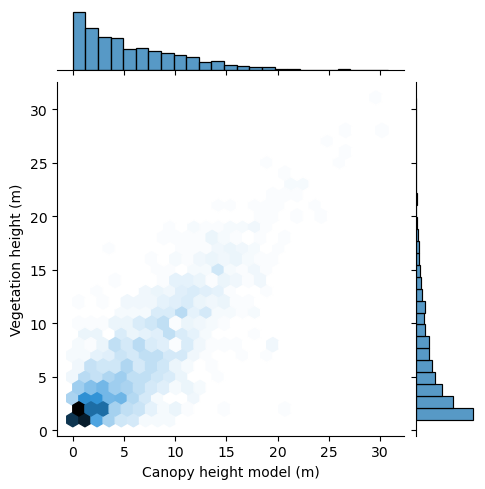

In [90]:
# How closely does the CHM match the vegetation height?
# Plot a scatter plot of the two variables
import seaborn as sns
from matplotlib import pyplot as plt

# Generate a modern looking scatter plot that shows the density of points by making then semi transparent
plot_subset = image_samples.sample(10000)
plot_subset = plot_subset[plot_subset["veg_height"] > 1]
plot = sns.jointplot(data=plot_subset, x="chm", y="veg_height", kind="hex", height=5)
# Add axis labels
plot.set_axis_labels("Canopy height model (m)", "Vegetation height (m)")

plot

There is a linear relationship between the vegetation height and the CHM but there is some error remaining. The are a lot of canopy height values which are >0 where the vegetation height is 0. This is consistent with what should be expected since the DSM will pick up features (like caravans) which have been removed by the algorithm which generates the vegetation height model. 

## Looking at Sentinel

For vegetation analysis using Sentinel-2 imagery:

- Red (B4): Useful for vegetation health.
- Green (B3): Also used in some vegetation indices.
- Near-Infrared (NIR, B8): Highly sensitive to vegetation.
- Short-Wave Infrared (SWIR, B11, B12): Helpful for moisture content.

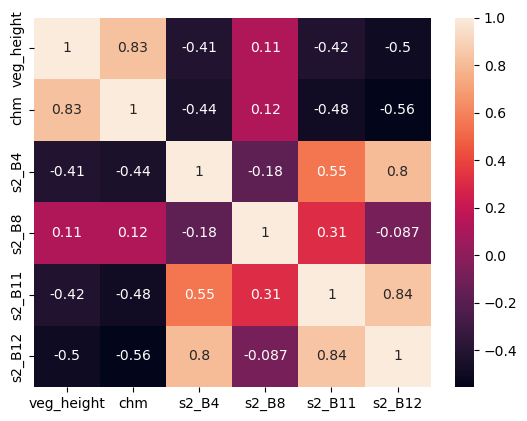

In [91]:
correlation_matrix = plot_subset[['veg_height', 'chm', 's2_B4', 's2_B8', 's2_B11', 's2_B12']].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

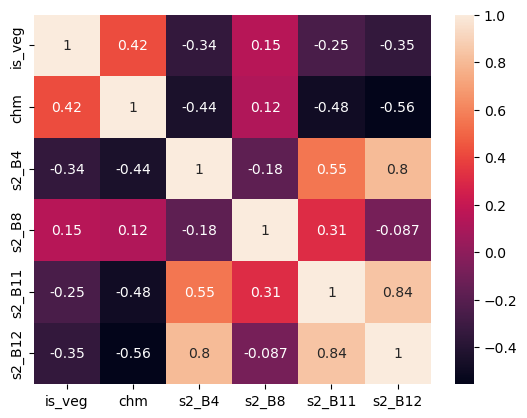

In [92]:
plot_subset["is_veg"] = plot_subset["veg_height"] > 2
correlation_matrix = plot_subset[['is_veg', 'chm', 's2_B4', 's2_B8', 's2_B11', 's2_B12']].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

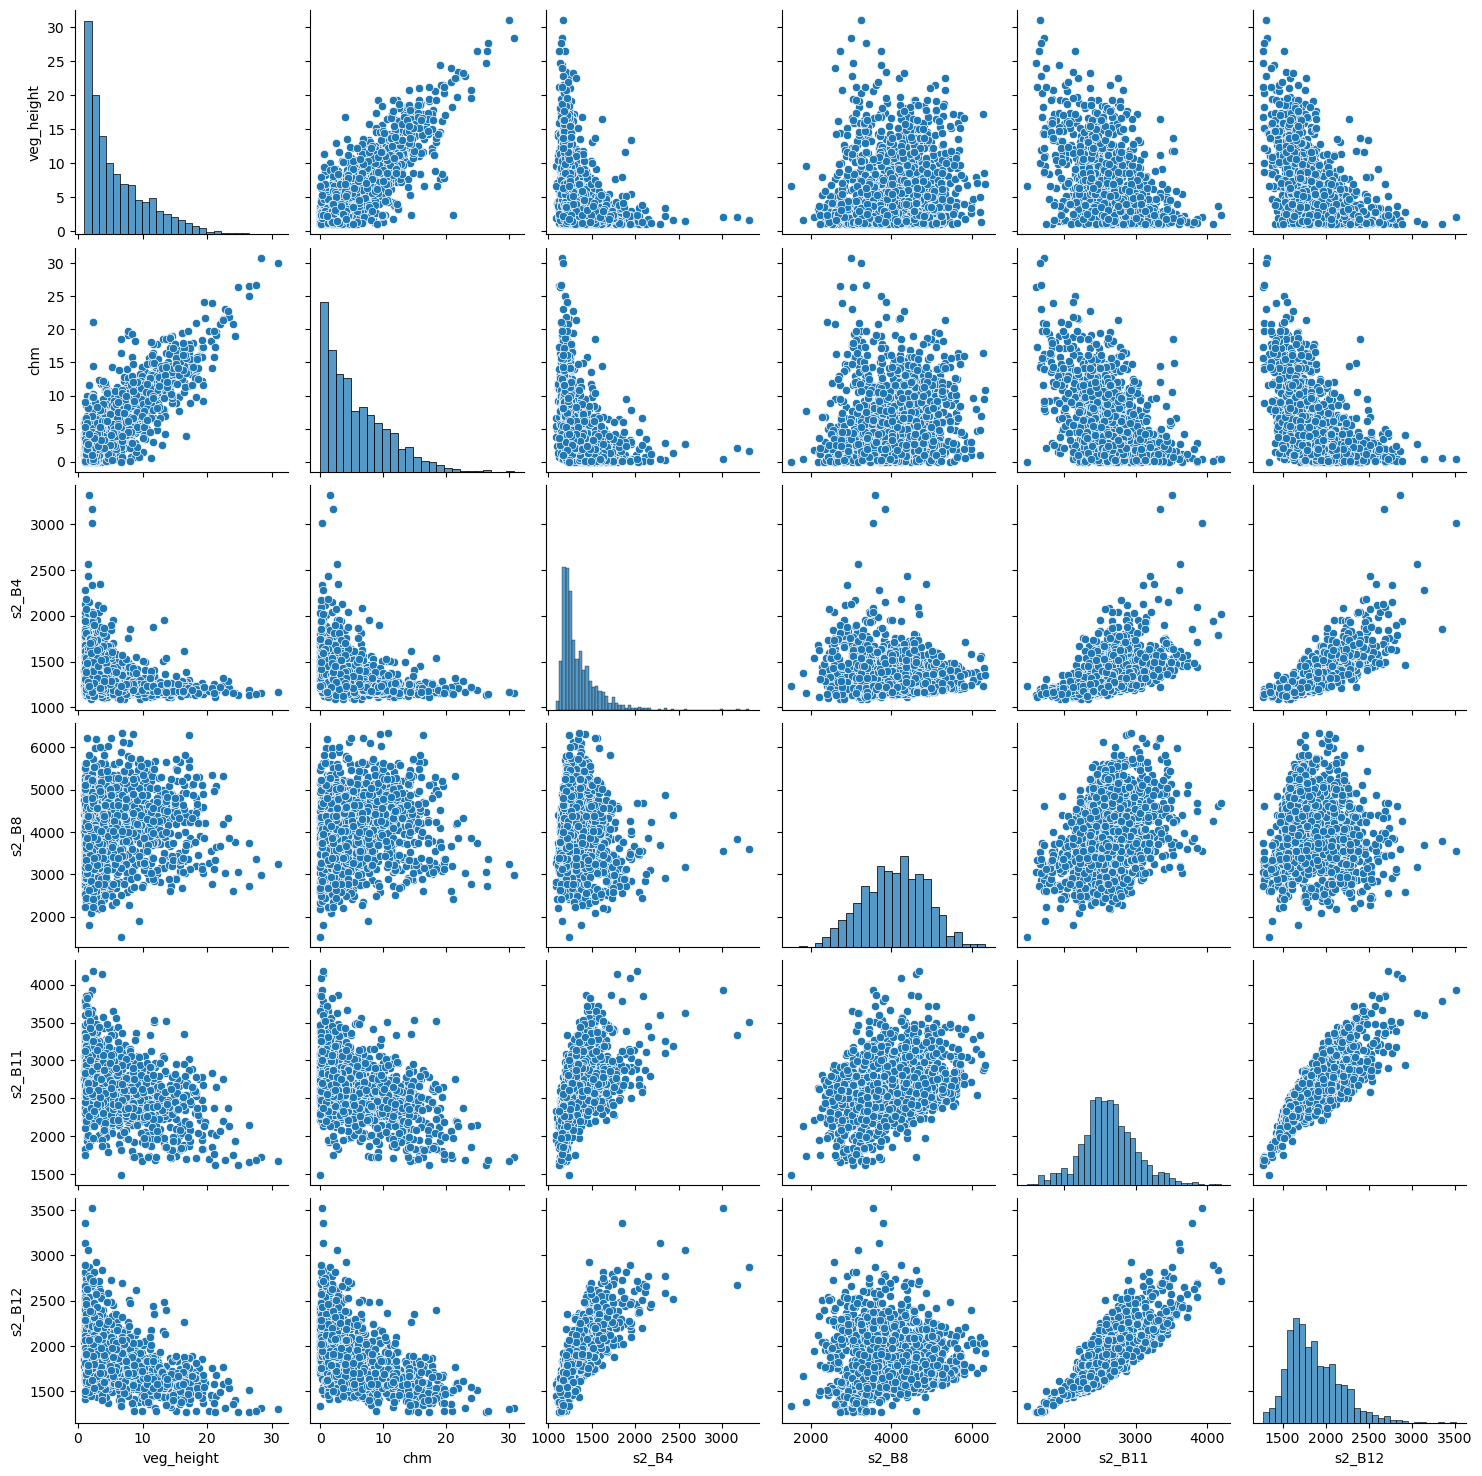

In [93]:
sns.pairplot(plot_subset[['veg_height', 'chm', 's2_B4', 's2_B8', 's2_B11', 's2_B12']])
plt.show()


# Modelling

First try to predict which pixels are vegetation and which are not. Then try to predict the vegetation height.

### Feature Engineering

In [94]:
# Identify vegetation
image_samples['is_veg'] = image_samples['veg_height'] > 2
image_samples['is_veg'] = image_samples['is_veg'].astype(int)

# NDVI
image_samples['ndvi'] = (image_samples['s2_B8'] - image_samples['s2_B4']) / (image_samples['s2_B8'] + image_samples['s2_B4'])

# NDWI
image_samples['ndwi'] = (image_samples['s2_B8'] - image_samples['s2_B11']) / (image_samples['s2_B8'] + image_samples['s2_B11'])

# Interaction of canopy height model and NDVI
image_samples['chm_ndvi'] = image_samples['chm'] * image_samples['ndvi']

# Soil adjusted vegetation index
image_samples['savi'] = ((image_samples['s2_B8'] - image_samples['s2_B4']) / (image_samples['s2_B8'] + image_samples['s2_B4'] + 0.5)) * (1.5)

# Enhanced vegetation index
image_samples['evi'] = 2.5 * ((image_samples['s2_B8'] - image_samples['s2_B4']) / (image_samples['s2_B8'] + 6 * image_samples['s2_B4'] - 7.5 * image_samples['s2_B2'] + 1))

image_samples.replace([np.inf, -np.inf], np.nan, inplace=True)
image_samples.dropna(inplace=True)

The model needs to differentiate between vegetation and non vegetation to then be able to accurately predict the vegetation height. I'm acheiving this by combining two random forest models in a pipeline

In [95]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow
import mlflow.sklearn
    # Check accuracy
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
# Make a naive version of the model


In [96]:
X_class = image_samples[['chm', 'ndvi', 'ndwi', 'chm_ndvi', 's2_B4', 's2_B8', 's2_B11', 's2_B12', 'savi', 'evi']]
y_class = image_samples['is_veg'].astype(int)
# Prepare data for regression
X_regress = image_samples[['chm', 'ndvi', 'dtm', 'dsm']]
y_regress = image_samples['veg_height']

# Classification & Regression Models

In [97]:
from sklearn.ensemble import RandomForestRegressor


class VegetationRFModel:
    def __init__(self, cls_params: dict, reg_params: dict, n_jobs: int = -1):
        self.cls_model = RandomForestClassifier(
            n_jobs=n_jobs, random_state=42, **cls_params
        )
        self.reg_model = RandomForestRegressor(
            n_jobs=n_jobs, random_state=42, **reg_params
        )
        self.fitted = False

    def fit(self, X: np.ndarray, y: np.ndarray):
        # Convert vegetation height to a binary class - is it vegetation or not?
        y_class = y >= 2.0
        self.cls_model.fit(X, y_class)

        # Add the predicted class as a feature
        is_veg = self.cls_model.predict(X)
        is_veg = is_veg[:, np.newaxis]
        X = np.hstack([X, is_veg])
        # Fit the regression model
        self.reg_model.fit(X, y)
        self.fitted = True

    def predict(self, X: np.ndarray):
        # Predict the class
        is_veg = self.cls_model.predict(X)
        is_veg = is_veg[:, np.newaxis]
        X = np.hstack([X, is_veg])
        # Predict the vegetation height
        return self.reg_model.predict(X)

    def cls_accuracy(self, X: np.ndarray, y: np.ndarray) -> float:
        y_pred = self.cls_model.predict(X)
        y_class = y >= 2.0
        y_class = y_class.astype(int)
        return accuracy_score(y_class, y_pred)

    def score(self, X: np.ndarray, y: np.ndarray) -> dict:
        y_pred = self.predict(X)
        mse = mean_squared_error(y, y_pred)
        mae = mean_absolute_error(y, y_pred)
        r2 = r2_score(y, y_pred)

        return {"mse": mse, "mae": mae, "r2": r2}


X = image_samples[
    [
        "chm",
        "ndvi",
        "ndwi",
        "chm_ndvi",
        "s2_B4",
        "s2_B8",
        "s2_B11",
        "s2_B12",
        "savi",
        "evi",
    ]
]
y = image_samples["veg_height"]

with mlflow.start_run():
    model_cls_rgr = VegetationRFModel(
        cls_params={"n_estimators": 200, "max_depth": 10},
        reg_params={"n_estimators": 200, "max_depth": 10},
    )

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Fit the model
    model_cls_rgr.fit(X_train, y_train)

    # Log the model
    mlflow.sklearn.log_model(model_cls_rgr, "model")

    # Log the parameters
    mlflow.log_params(model_cls_rgr.cls_model.get_params())

    # Log the model type
    mlflow.set_tag("model_type", "Random Forest Classification and Regression")

    # Log the metrics
    metrics = model_cls_rgr.score(X_test, y_test)
    mlflow.log_metrics(metrics)
    print(metrics)
    # Log classification accuracy
    mlflow.log_metric("cls_acc", model_cls_rgr.cls_accuracy(X_test, y_test))

{'mse': 1.5353079351039227, 'mae': 0.46662567468058647, 'r2': 0.8291910431929379}


# Make Predictions

In [98]:
# Raster calcs
def calculate_chm(dsm, dtm):
    return dsm - dtm

def calculate_ndvi(b4, b8):
    return (b8 - b4) / (b8 + b4)

def calculate_ndwi(b8, b11):
    return (b8 - b11) / (b8 + b11)

def calculate_savi(b4, b8):
    return ((b8 - b4) / (b8 + b4 + 0.5)) * (1.5)

def calculate_evi(b4, b8, b2):
    return 2.5 * ((b8 - b4) / (b8 + 6 * b4 - 7.5 * b2 + 1))


In [142]:
# Predict the vegetation height across the whole area
# Select and arrange the bands

image_predict = image_stack.copy()


image_predict['chm'] = calculate_chm(image_predict['dsm'], image_predict['dtm'])
image_predict['ndvi'] = calculate_ndvi(image_predict['s2_B4'], image_predict['s2_B8'])
image_predict['ndwi'] = calculate_ndwi(image_predict['s2_B8'], image_predict['s2_B11'])
image_predict['savi'] = calculate_savi(image_predict['s2_B4'], image_predict['s2_B8'])
image_predict['evi'] = calculate_evi(image_predict['s2_B4'], image_predict['s2_B8'], image_predict['s2_B2'])
image_predict['chm_ndvi'] = image_predict['chm'] * image_predict['ndvi']

input_vars =     [
        "chm",
        "ndvi",
        "ndwi",
        "chm_ndvi",
        "s2_B4",
        "s2_B8",
        "s2_B11",
        "s2_B12",
        "savi",
        "evi",
    ]

image_predict = image_predict[input_vars]

# Replace nodata values with 0
# They can then be converted back using a mask
# Make a mask of null or inf or nan values
null_mask = np.isinf(image_predict.to_array()).any(axis=0) | np.isnan(image_predict.to_array()).any(axis=0)

# Replace null values with 0
image_predict = image_predict.where(~null_mask, 0)

In [138]:
# Set the dtype to float32
image_predict = image_predict.astype(np.float32)
# Deal with na or inf values, set them to zero
image_predict = image_predict.where(~np.isnan(image_predict), 0)
image_predict = image_predict.where(~np.isinf(image_predict), 0)

In [139]:
from tempfile import NamedTemporaryFile
import elapid as ela

with NamedTemporaryFile(suffix=".tif") as tmp_X:
    image_predict.rio.to_raster(tmp_X.name)
    with NamedTemporaryFile(suffix=".tif") as tmp_pred:
        ela.apply_model_to_rasters(
            model = model_cls_rgr,
            raster_paths=[tmp_X.name],
            output_path=tmp_pred.name,
        )
        predicted = rxr.open_rasterio(tmp_pred.name)

/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Window:   0%|                              | 0/4212 [00:00<?, ?it/s]

In [146]:
predicted_reprj = predicted.rio.reproject_match(veg_height)
predicted_reprj = predicted_reprj.where(~null_mask,np.nan)
predicted_reprj = predicted_reprj.squeeze()

# Calculate the error from the predicted vegetation height
error = predicted_reprj - veg_height

# WRite both to disk
predicted_reprj.rio.to_raster('data/processed/predicted-veg-height.tif')
error.rio.to_raster('data/processed/predicted-veg-height-error.tif')

/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


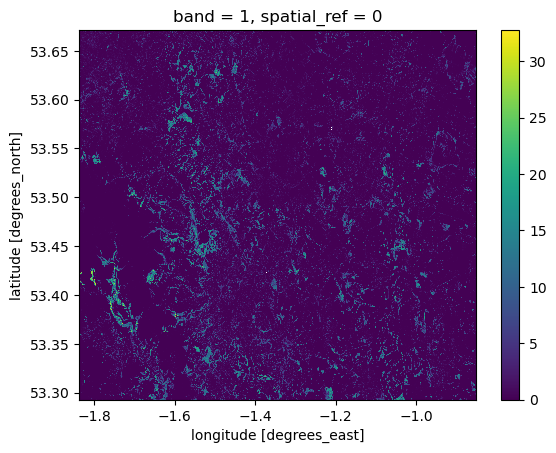

In [153]:
predicted_reprj.plot()